<a href="https://colab.research.google.com/github/BrajanNieto/MultiDiag-AI/blob/main/Anemic_Model_BN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IA Fundamentals - Anemia Detection using CNN**

---

This notebook contains the implementation and experimental analysis of Convolutional Neural Networks (CNN) applied to the automated detection of anemia. The project focuses on the processing of palpebral conjunctiva images captured via smartphone to provide a non-invasive pre-diagnosis. It evaluates:

* **Architecture Performance:** Comparison between custom CNN architectures and Transfer Learning models (e.g., MobileNetV2, EfficientNet).
* **Image Optimization:** Preprocessing techniques including color constant algorithms and ROI (Region of Interest) extraction.
* **Medical Evaluation Metrics:** Focus on Sensitivity (Recall) and F1-Score to ensure high reliability in clinical screening.

**Authors:**

Brajan Esteban Nieto Espinoza  
[brajan.nieto@utec.edu.pe](mailto:brajan.nieto@utec.edu.pe)

Mateo Tapia Chasquibol  

Sebastián López Medina  

---

In [1]:
import os

# 1. Clonar el repositorio (solo si no existe ya)
if not os.path.exists('/content/MultiDiag-AI'):
    !git clone https://github.com/BrajanNieto/MultiDiag-AI.git
else:
    print("El repositorio ya está clonado. Haciendo pull para actualizar...")
    !cd /content/MultiDiag-AI && git pull

# 2. Definir la ruta base
BASE_PATH = '/content/MultiDiag-AI'

Cloning into 'MultiDiag-AI'...
remote: Enumerating objects: 1589, done.
remote: Total 1589 (delta 0), reused 0 (delta 0), pack-reused 1589 (from 2)
Receiving objects: 100% (1589/1589), 639.90 MiB | 18.31 MiB/s, done.
Updating files: 100% (1576/1576), done.


In [4]:
import pandas as pd
import os
import glob

# ==========================================
# CONFIGURACIÓN DE FILTROS (India / Italy)
# ==========================================
# Cambia esto si quieres entrenar con la otra vista del ojo
SUFFIX_INCLUDE = "palpebral.png"
SUFFIX_EXCLUDE = "forniceal_palpebral.png" # Excluir explícitamente esta para evitar confusión

# Ruta base del repositorio clonado
BASE_PATH = '/content/MultiDiag-AI'

def procesar_cp_anemic(dataset_name):
    """Procesa el dataset de Ghana (CP-AnemiC)"""
    folder_path = os.path.join(BASE_PATH, dataset_name)
    xlsx_path = os.path.join(folder_path, 'Anemia_Data_Collection_Sheet.xlsx')

    print(f"Procesando {dataset_name}...")

    # Cargar Excel
    try:
        df_raw = pd.read_excel(xlsx_path)
    except FileNotFoundError:
        print(f"No se encontró el Excel en: {xlsx_path}")
        return []

    data = []

    # Buscar todas las imágenes primero para hacer match rápido
    # Buscamos recursivamente en todas las subcarpetas de CP-AnemiC
    todas_imagenes = glob.glob(os.path.join(folder_path, '**', '*'), recursive=True)
    mapa_imagenes = {os.path.basename(f).split('.')[0]: f for f in todas_imagenes if f.endswith(('.png', '.jpg', '.jpeg', '.bmp'))}

    for _, row in df_raw.iterrows():
        img_id = str(row['IMAGE_ID']).strip() # Ej: Image_001

        # Buscar la ruta real de la imagen usando el mapa
        full_path = mapa_imagenes.get(img_id)

        if full_path:
            data.append({
                'Ruta_Imagen': full_path,
                'Hemoglobina': row['HB_LEVEL'],
                'Genero': row['GENDER'],
                'Edad': row['Age(Months)'], # OJO: Aquí está en MESES
                'Dataset_Origen': 'CP-AnemiC (Ghana)'
            })

    print(f"{dataset_name}: {len(data)} imágenes encontradas.")
    return data

def procesar_india_italy(dataset_name):
    """Procesa datasets con estructura de carpetas numéricas (India e Italy)"""
    folder_path = os.path.join(BASE_PATH, dataset_name)
    xlsx_name = f"{dataset_name}.xlsx" # Ej: India.xlsx o Italy.xlsx
    xlsx_path = os.path.join(folder_path, xlsx_name)

    print(f"Procesando {dataset_name}...")

    try:
        df_raw = pd.read_excel(xlsx_path)
    except FileNotFoundError:
        print(f"No se encontró el Excel en: {xlsx_path}")
        return []

    data = []

    for _, row in df_raw.iterrows():
        # En India/Italy el ID de carpeta es la columna 'Number'
        folder_id = str(row['Number'])
        target_folder = os.path.join(folder_path, folder_id)

        if os.path.exists(target_folder):
            # Listar archivos en la carpeta numerada
            files = os.listdir(target_folder)

            # Filtro inteligente: Termina en 'palpebral.png' PERO NO es 'forniceal...'
            selected_img = [f for f in files if f.endswith(SUFFIX_INCLUDE) and SUFFIX_EXCLUDE not in f]

            if selected_img:
                # Tomamos la primera coincidencia (debería ser única tras el filtro)
                full_path = os.path.join(target_folder, selected_img[0])

                data.append({
                    'Ruta_Imagen': full_path,
                    'Hemoglobina': row['Hgb'],
                    'Genero': row['Gender'], # Puede ser M/F
                    'Edad': row['Age'],      # OJO: Aquí suele estar en AÑOS
                    'Dataset_Origen': dataset_name
                })
        else:
            # A veces los excel tienen filas extra sin carpeta correspondiente
            pass

    print(f"{dataset_name}: {len(data)} imágenes encontradas.")
    return data

# ==========================================
# EJECUCIÓN PRINCIPAL
# ==========================================
all_data = []

# 1. CP-AnemiC
if 'CP-AnemiC dataset' in ['CP-AnemiC dataset', 'India', 'Italy']:
    all_data.extend(procesar_cp_anemic('CP-AnemiC dataset'))

# 2. India
if 'India' in ['CP-AnemiC dataset', 'India', 'Italy']:
    all_data.extend(procesar_india_italy('India'))

# 3. Italy
if 'Italy' in ['CP-AnemiC dataset', 'India', 'Italy']:
    all_data.extend(procesar_india_italy('Italy'))

# Crear DataFrame Final
df_final = pd.DataFrame(all_data)

# MOSTRAR RESULTADOS
print("\n" + "="*40)
print(f"TOTAL DE IMÁGENES RECOPILADAS: {len(df_final)}")
print("="*40)
print(df_final.head())
print("\nDistribución por origen:")
print(df_final['Dataset_Origen'].value_counts())

Procesando CP-AnemiC dataset...
CP-AnemiC dataset: 710 imágenes encontradas.
Procesando India...
India: 94 imágenes encontradas.
Procesando Italy...
Italy: 122 imágenes encontradas.

TOTAL DE IMÁGENES RECOPILADAS: 926
                                         Ruta_Imagen Hemoglobina  Genero  \
0  /content/MultiDiag-AI/CP-AnemiC dataset/Anemic...         9.8  Female   
1  /content/MultiDiag-AI/CP-AnemiC dataset/Anemic...         9.9    Male   
2  /content/MultiDiag-AI/CP-AnemiC dataset/Non-an...        11.1  Female   
3  /content/MultiDiag-AI/CP-AnemiC dataset/Non-an...        12.5    Male   
4  /content/MultiDiag-AI/CP-AnemiC dataset/Anemic...         9.9    Male   

   Edad     Dataset_Origen  
0     6  CP-AnemiC (Ghana)  
1    24  CP-AnemiC (Ghana)  
2    24  CP-AnemiC (Ghana)  
3    12  CP-AnemiC (Ghana)  
4    24  CP-AnemiC (Ghana)  

Distribución por origen:
Dataset_Origen
CP-AnemiC (Ghana)    710
Italy                122
India                 94
Name: count, dtype: int64



--- Muestra Aleatoria de Datos Procesados ---
        Dataset_Origen  Hemoglobina  Edad_Anios Genero_Unif
228  CP-AnemiC (Ghana)          6.5         4.0           M
515  CP-AnemiC (Ghana)          9.6         1.0           F
792              India          9.5        32.0           F
182  CP-AnemiC (Ghana)          4.2         2.0           F
846              Italy         14.7        59.0           M
819              Italy         13.5        55.0           M
379  CP-AnemiC (Ghana)         13.6         3.0           F
492  CP-AnemiC (Ghana)         12.1         2.0           F
708  CP-AnemiC (Ghana)         12.1         4.0           M
805              Italy         10.2        77.0           F

--- Promedios por Dataset ---
                   Hemoglobina  Edad_Anios
Dataset_Origen                            
CP-AnemiC (Ghana)    10.358521    2.632277
India                11.495745   33.744681
Italy                13.734623   49.434426


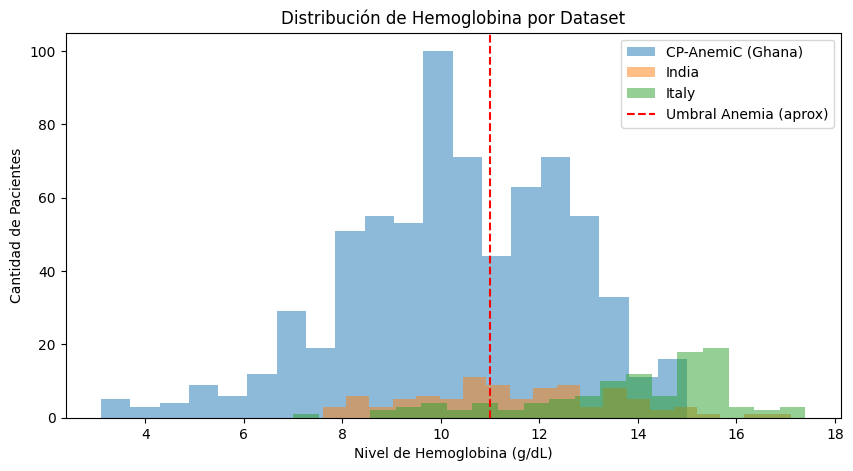

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 4. LIMPIEZA Y ESTANDARIZACIÓN DE DATOS
# ==========================================

# A) Estandarizar EDAD a AÑOS
# Si es de CP-AnemiC, dividimos por 12. Si es India/Italy, lo dejamos igual.
def normalizar_edad(row):
    if row['Dataset_Origen'] == 'CP-AnemiC (Ghana)':
        return row['Edad'] / 12.0  # Convertir meses a años
    else:
        return row['Edad']

df_final['Edad_Anios'] = df_final.apply(normalizar_edad, axis=1)

# B) Estandarizar GÉNERO
# Mapeamos todo a 0 (Mujer) y 1 (Hombre) o texto uniforme
mapa_genero = {
    'Female': 'F', 'Male': 'M',
    'F': 'F', 'M': 'M',
    'female': 'F', 'male': 'M'
}
df_final['Genero_Unif'] = df_final['Genero'].map(mapa_genero)

# C) Convertir Hemoglobina a numérico (por si acaso hay texto sucio)
df_final['Hemoglobina'] = pd.to_numeric(df_final['Hemoglobina'], errors='coerce')

# ==========================================
# 5. VERIFICACIÓN VISUAL (¡La prueba de fuego!)
# ==========================================

# Mostrar 10 filas ALEATORIAS (para ver mezcla de Ghana, India e Italia)
print("\n--- Muestra Aleatoria de Datos Procesados ---")
print(df_final[['Dataset_Origen', 'Hemoglobina', 'Edad_Anios', 'Genero_Unif']].sample(10))

# Estadísticas por Dataset
print("\n--- Promedios por Dataset ---")
print(df_final.groupby('Dataset_Origen')[['Hemoglobina', 'Edad_Anios']].mean())

# Gráfico de Distribución de Hemoglobina
plt.figure(figsize=(10, 5))
for dataset in df_final['Dataset_Origen'].unique():
    subset = df_final[df_final['Dataset_Origen'] == dataset]
    plt.hist(subset['Hemoglobina'], bins=20, alpha=0.5, label=dataset)

plt.axvline(x=11, color='r', linestyle='--', label='Umbral Anemia (aprox)')
plt.title('Distribución de Hemoglobina por Dataset')
plt.xlabel('Nivel de Hemoglobina (g/dL)')
plt.ylabel('Cantidad de Pacientes')
plt.legend()
plt.show()